**Mediapipe extract**

In [78]:
import cv2
import os, sys, gc
import time
import numpy as np
import mediapipe as mp
# from tqdm.auto import tqdm
import multiprocessing
from joblib import Parallel, delayed
from natsort import natsorted
from glob import glob
import math
import pickle
import json

mp_holistic = mp.solutions.holistic

N_FACE_LANDMARKS = 468
N_BODY_LANDMARKS = 33
N_HAND_LANDMARKS = 21


class Counter(object):
    # https://stackoverflow.com/a/47562583/
    def __init__(self, initval=0):
        self.val = multiprocessing.RawValue("i", initval)
        self.lock = multiprocessing.Lock()

    def increment(self):
        with self.lock:
            self.val.value += 1

    @property
    def value(self):
        return self.val.value


def process_body_landmarks(component, n_points):
    kps = np.zeros((n_points, 3))
    conf = np.zeros(n_points)
    if component is not None:
        landmarks = component.landmark
        kps = np.array([[p.x, p.y, p.z] for p in landmarks])
        conf = np.array([p.visibility for p in landmarks])
    return kps, conf


def process_other_landmarks(component, n_points):
    kps = np.zeros((n_points, 3))
    conf = np.zeros(n_points)
    if component is not None:
        landmarks = component.landmark
        kps = np.array([[p.x, p.y, p.z] for p in landmarks])
        conf = np.ones(n_points)
    return kps, conf


def get_holistic_keypoints(
    frames, holistic=mp_holistic.Holistic(static_image_mode=False, model_complexity=2)
):
    """
    For videos, it's optimal to create with `static_image_mode=False` for each video.
    https://google.github.io/mediapipe/solutions/holistic.html#static_image_mode

    Static_image_mode => theo doi moc được detected từ đầu, không cần phát hiện khác cho đến khi mất dấu.
    """

    keypoints = []
    confs = []

    for frame in frames:
        results = holistic.process(frame)

        body_data, body_conf = process_body_landmarks(
            results.pose_landmarks, N_BODY_LANDMARKS
        )
        face_data, face_conf = process_other_landmarks(
            results.face_landmarks, N_FACE_LANDMARKS
        )
        lh_data, lh_conf = process_other_landmarks(
            results.left_hand_landmarks, N_HAND_LANDMARKS
        )
        rh_data, rh_conf = process_other_landmarks(
            results.right_hand_landmarks, N_HAND_LANDMARKS
        )

        data = np.concatenate([body_data, face_data, lh_data, rh_data])
        conf = np.concatenate([body_conf, face_conf, lh_conf, rh_conf])

        keypoints.append(data)
        confs.append(conf)

    # TODO: Reuse the same object when this issue is fixed: https://github.com/google/mediapipe/issues/2152
    holistic.close()
    del holistic
    gc.collect()

    keypoints = np.stack(keypoints)
    confs = np.stack(confs)
    return keypoints, confs


def gen_keypoints_for_frames(frames, save_path):

    pose_kps, pose_confs = get_holistic_keypoints(frames)
    body_kps = np.concatenate([pose_kps[:, :33, :], pose_kps[:, 501:, :]], axis=1)

    confs = np.concatenate([pose_confs[:, :33], pose_confs[:, 501:]], axis=1)

    d = {"keypoints": body_kps, "confidences": confs}

    with open(save_path + ".pkl", "wb") as f:
        pickle.dump(d, f, protocol=4)

if __name__ == "__main__":

    with open("C:/Users/bvinh/GDP/WLASL/dataset/nslt_3.json", "r") as f:
        data = json.load(f)

    data.keys()
    print(type(data.keys()))

    list_id = list(data.keys())

    dir_videos = "C:/Users/bvinh/GDP/WLASL/dataset/cutvideo/"
    save_pkl = "D:/Personalproject/OpenHands/data_out"
    dir_input = []
    save_dirs = []
    for idx in range(0, len(list_id)):
        dir_video = os.path.join(dir_videos, list_id[idx] + ".mp4")
        save_dir = os.path.join(save_pkl, list_id[idx])
        dir_input.append(dir_video)
        save_dirs.append(save_dir)
        frames = []
        vidcap = cv2.VideoCapture(dir_video)
        while vidcap.isOpened():
            success, img = vidcap.read()
            if not success:
                print("No frame available")
                break
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (640,480))

            frames = np.asarray(frames.append(img))
            print(np.shape(frames))
            print(type(frames))
            gen_keypoints_for_frames(frames, save_dir)
        print("=" * 30 + "{}".format("Done: " + str(idx))+ "="*30)
    print("Done!!!!")

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/bvinh/GDP/WLASL/dataset/nslt_3.json'

**Test video**

In [ ]:
import cv2


video_path = "D:\Personalproject\OpenHands\data_in/17023.mp4"
vidcap = cv2.VideoCapture(video_path)
frames = []
while vidcap.isOpened():
    success, imga = vidcap.read()
    if not success:
        print("Not success img in video")
        break
    img = cv2.cvtColor(imga, cv2.COLOR_BGR2RGB)
    frames.append(img)

vidcap.release()
print(type(imga))
print(type(img))
print(type(frames))


Not success img in video
<class 'NoneType'>
<class 'numpy.ndarray'>
<class 'list'>


**Copy video to folder**

In [ ]:
import shutil
DIR = "D:\Personalproject\OpenHands\data_in"
SAVE_DIR = "D:\Personalproject\OpenHands\data_out"
for file in os.listdir(DIR):
    file_path = os.path.join(DIR,file)
    save_path = os.path.join(SAVE_DIR, file)
    shutil.copy(file_path, save_path)
    print("Done") 

In [ ]:
import json, shutil

path_json = "D:/Personalproject/OpenHands/HAO_lost_video.json"

with open(path_json, "r") as f:
    HAO_data = json.load(f)

DIR_DATASET = "D:/Personalproject/GDP/WLASL/dataset/videos/"
DIR_SAVE = "D:/Personalproject/dataset/HAO/Video"

for idx in range(len(HAO_data)):
    gloss =  HAO_data[idx]['gloss']
    list_key = HAO_data[idx].keys()
    # print(list_key)
    gloss_folder = DIR_SAVE + "/{}".format(gloss)
    print(gloss_folder)
    # print(len(gloss_folder))
    # os.mkdir(gloss_folder)
    # print("Done {}".format(gloss))

    for idy in range(len(HAO_data[idx]['video available'])):
        video_id = HAO_data[idx]['video available'][idy]
        
        DIR_VIDEO = DIR_DATASET + "{}.mp4".format(video_id)
        SAVE_VIDEO =  gloss_folder + "/{}.mp4".format(video_id)
        shutil.copy(DIR_VIDEO, SAVE_VIDEO)
    print("="*30 + "{}".format(gloss) + ": " + "{}".format( len(HAO_data[idx]['video available'])))
print("Done!")



D:/Personalproject/dataset/HAO/Video/fine
==============================fine: 9
D:/Personalproject/dataset/HAO/Video/want
==============================want: 9
D:/Personalproject/dataset/HAO/Video/right
==============================right: 9
D:/Personalproject/dataset/HAO/Video/help
==============================help: 14
D:/Personalproject/dataset/HAO/Video/hurt
==============================hurt: 5
D:/Personalproject/dataset/HAO/Video/good
==============================good: 10
D:/Personalproject/dataset/HAO/Video/hospital
==============================hospital: 7
D:/Personalproject/dataset/HAO/Video/because
==============================because: 10
D:/Personalproject/dataset/HAO/Video/head
==============================head: 6
D:/Personalproject/dataset/HAO/Video/left
==============================left: 5
D:/Personalproject/dataset/HAO/Video/shoulder
==============================shoulder: 4
D:/Personalproject/dataset/HAO/Video/throat
==============================throat: 5
Done!


In [ ]:
import json
import numpy as np
import shutil
import os


path_json = "D:\Personalproject\GDP\WLASL\dataset\WLASL_v0.3.json"
with open(path_json, "r") as f:
    wlasl = json.load(f)


dir_dataset = "D:\Personalproject\OpenHands\datasets/wlasl_data"
os.chdir(dir_dataset)

gloss = wlasl[1]["gloss"]
os.makedirs(gloss)
for idx in range(len(wlasl)):
    gloss = wlasl[idx]["gloss"]
    
    # os.mkdir(path)




**Make dataset**

In [ ]:
gloss_dict = ['allergy', 'appointment', 'arm', 'bad', 'bell', 'beside', 'between', 'blood', 'bone', 'brain', 'break', 'burp', 'buy', 'can', 'check', 'cool', 'cost', 'deaf', 'diarrhea', 'dizzy', 'doctor', "don't want", 'ear', 'everyday', 'eyes', 'face', 'feel', 'fine', 'forget', 'good', 'hard', 'head', 'headache', 'help', 'hospital', 'hot', 'hurt', 'infection', 'left', 'medicine', 'my', 'neck', 'normal', 'not', 'nurse', 'often', 'pain', 'pneumonia', 'recent', 'right', 'shoulder', 'sick', 'skin', 'sometimes', 'sore throat', 'surgeon', 'surgery', 'teeth', 'throat', 'tired', 'vomit', 'want', 'where', "i", "because"]

glos_dict_88 = ['allergy', 'appointment', 'arm', 'bad', 'bell', 'beside', 'between', 'blood', 'bone', 'brain', 'break', 'burp', 'buy', 'can', 'check', 'cool', 'cost', 'deaf', 'diarrhea', 'dizzy', 'doctor', "don't want", 'ear', 'everyday', 'eyes', 'face', 'feel', 'fine', 'forget', 'good', 'hard', 'head', 'headache', 'help', 'hospital', 'hot', 'hurt', 'infection', 'left', 'medicine', 'my', 'neck', 'normal', 'not', 'nurse', 'often', 'pain', 'pneumonia', 'recent', 'right', 'shoulder', 'sick', 'skin', 'sometimes', 'sore throat', 'surgeon', 'surgery', 'teeth', 'throat', 'tired', 'vomit', 'want', 'where', "a", "b", "c", "d", "e", "f", "g", "h" ,"i" ,"k" , "l" , "m", "n", "o", "p", "q", "r", "s", "t", "u", "v", "w", "x", "y", "z"]


print(len(gloss_dict))

# gloss_5 = ["doctor", "deaf", "teeth", "help", "pain", "medicine"]
# gloss_10 = ["doctor", "deaf", "help", "pain", "medicine", "hospital", "allergy", "can", "not", "my"]
# gloss_15 = ["appointment", ""]
# gloss_30 = []
# gloss_50 = []

65


In [ ]:
gloss_dict.sort()
print(gloss_dict)

['allergy', 'appointment', 'arm', 'bad', 'because', 'bell', 'beside', 'between', 'blood', 'bone', 'brain', 'break', 'burp', 'buy', 'can', 'check', 'cool', 'cost', 'deaf', 'diarrhea', 'dizzy', 'doctor', "don't want", 'ear', 'everyday', 'eyes', 'face', 'feel', 'fine', 'forget', 'good', 'hard', 'head', 'headache', 'help', 'hospital', 'hot', 'hurt', 'i', 'infection', 'left', 'medicine', 'my', 'neck', 'normal', 'not', 'nurse', 'often', 'pain', 'pneumonia', 'recent', 'right', 'shoulder', 'sick', 'skin', 'sometimes', 'sore throat', 'surgeon', 'surgery', 'teeth', 'throat', 'tired', 'vomit', 'want', 'where']


**Create .json**

In [ ]:
gloss_5 = ["deaf", "allergy", "i", "often", "tired"]

gloss_10 = ["allergy", "deaf", "diarrhea","infection","i", "pneumonia", "doctor", "sore throat", "tired", "check"]



print(len(gloss_10))


gloss_20 = ['allergy', 'because', 'buy', 'check', 'deaf', 'diarrhea', 'dizzy' , 'doctor', "hospital",'head', 'help', 'i', 'infection', 'medicine', 'often', 'pneumonia', 'sore throat', 'throat', 'tired',  'vomit','want', 'hurt', 'shoulder', 'right', 'left', "fine", "good"]

print(len(gloss_20))

10
27


In [ ]:
import numpy as np

split_gloss = []
for gloss in gloss_20:
    if gloss not in gloss_10:
        split_gloss.append(gloss)
print(split_gloss)
print(len(split_gloss))

['because', 'buy', 'dizzy', 'hospital', 'head', 'help', 'medicine', 'often', 'throat', 'vomit', 'want', 'hurt', 'shoulder', 'right', 'left', 'fine', 'good']
17


In [ ]:
gloss_N =[]
choose_gloss = [split_gloss[1], split_gloss[2],  split_gloss[6], split_gloss[7], split_gloss[9]]
print(choose_gloss)

gloss_N = gloss_10 + choose_gloss
print(gloss_N)
print(len(gloss_N))

['buy', 'dizzy', 'medicine', 'often', 'vomit']
['allergy', 'deaf', 'diarrhea', 'infection', 'i', 'pneumonia', 'doctor', 'sore throat', 'tired', 'check', 'buy', 'dizzy', 'medicine', 'often', 'vomit']
15


In [ ]:
import numpy as np


gloss_H = []
for gloss in gloss_20:
    if gloss not in gloss_N:
        gloss_H.append(gloss)
print(gloss_H)
print(len(gloss_H))

['because', 'hospital', 'head', 'help', 'throat', 'want', 'hurt', 'shoulder', 'right', 'left', 'fine', 'good']
12


In [ ]:
print(gloss_H)
print(gloss_N)

['because', 'hospital', 'head', 'help', 'throat', 'want', 'hurt', 'shoulder', 'right', 'left', 'fine', 'good']
['allergy', 'deaf', 'diarrhea', 'infection', 'i', 'pneumonia', 'doctor', 'sore throat', 'tired', 'check', 'buy', 'dizzy', 'medicine', 'often', 'vomit']


In [ ]:
gloss_dict = gloss_H + gloss_N

In [ ]:
import json
import pandas as pd
import numpy as np

with open("D:\Personalproject\GDP\WLASL\dataset\WLASL_v0.3.json", "r") as f:
    wlasl = json.load(f)

rewrite = []
gloss_class = []
i = 0
for idx in range(len(wlasl)):
  gloss = wlasl[idx]["gloss"]
  video_of_gloss = wlasl[idx]["instances"]

  if gloss in gloss_H:
    classes = {"gloss": gloss, "instances": video_of_gloss}
    rewrite.append(classes)


print("="*30 + "{}".format("final_json") + "="*30)

##Sorted rewrite with  alphabetically
rewrite = sorted(rewrite, key=lambda k: k['gloss'])

##Write .json file
json_object = json.dumps(rewrite, indent=4)
save_dir = "D:\Personalproject\OpenHands\WLASL_gloss_H.json"
with open(save_dir, "w") as outfile:
  outfile.write(json_object)
print(len(rewrite))
print("Done create .json!")
    

==============================final_json==============================
12
Done create .json!


In [ ]:
##Check gloss
#===== gloss H =====
with open("D:/Personalproject/OpenHands/WLASL_gloss_H.json", "r") as f:
    wlasl_H = json.load(f)

gloss_H_check = []
for idx in range(len(wlasl)):
    gloss_H_check.append(wlasl[idx]["gloss"])

gloss_H = sorted(gloss_H)
print(gloss_H)
print(gloss_H_check)
print("\n")


#===== gloss H =====
with open("D:/Personalproject/OpenHands/WLASL_gloss_N.json", "r") as f:
    wlasl_N = json.load(f)

gloss_N_check = []
for idy in range(len(wlasl_N)):
    gloss_N_check.append(wlasl_N[idy]["gloss"])

gloss_N = sorted(gloss_N)
print(gloss_N)
print(gloss_N_check)

['because', 'fine', 'good', 'head', 'help', 'hospital', 'hurt', 'left', 'right', 'shoulder', 'throat', 'want']
['because', 'fine', 'good', 'head', 'help', 'hospital', 'hurt', 'left', 'right', 'shoulder', 'throat', 'want']


['allergy', 'buy', 'check', 'deaf', 'diarrhea', 'dizzy', 'doctor', 'i', 'infection', 'medicine', 'often', 'pneumonia', 'sore throat', 'tired', 'vomit']
['allergy', 'buy', 'check', 'deaf', 'diarrhea', 'dizzy', 'doctor', 'i', 'infection', 'medicine', 'often', 'pneumonia', 'sore throat', 'tired', 'vomit']


Check video available in datasets videos

In [ ]:
import json
import os, shutil, sys
import numpy as np

DIR_DATASET = "D:/Personalproject/GDP/WLASL/dataset/videos"

path_json = "D:/Personalproject/OpenHands/WLASL_27.json"

with open(path_json, "r") as f:
    wlasl = json.load(f)

video_available = []
video_in_wlasl = []
video_loss_27 =[]

for file in os.listdir(DIR_DATASET):
    video_available.append(file.replace(".mp4", ""))

print("Video avalable in dataset: {}".format(len(video_available)))

for idx in range(len(wlasl)):
    gloss =  wlasl[idx]["gloss"]
    # print(" ===== Class: {}  have {} videos =====".format(gloss, len(wlasl[idx]["instances"])))
    video_id_lost = []
    for idy in range(len(wlasl[idx]["instances"])):
        video_id = wlasl[idx]["instances"][idy]["video_id"]
        video_in_wlasl.append(video_id)
        if video_id not in video_available:
            video_id_lost.append(video_id)
            video_loss_27.append(video_id)
    # print("Have {} lost video in dataset availabe".format(len(video_id_lost)))
    # print("Video_id_lost: {}".format(video_id_lost))

# print("Have {} lost video in dataset availabe".format(len(video_id_lost)))
print("video_in_wlasl: {}".format(len(video_in_wlasl)))
print("video_lost: {}".format(len(video_loss_27)))
print("Num video available for wlasl_27: {}".format(len(video_in_wlasl) - len(video_loss_27)))



Video avalable in dataset: 11986
video_in_wlasl: 365
video_lost: 158
Num video available for wlasl_27: 207


Get video_id -  get url_video

In [ ]:
import json
import os, shutil, sys
import numpy as np

DIR_DATASET = "D:/Personalproject/GDP/WLASL/dataset/videos"

path_json = "D:/Personalproject/OpenHands/WLASL_27.json"

with open(path_json, "r") as f:
    wlasl = json.load(f)

video_available = []
video_in_wlasl = []
video_id_lost = []
num_id_lost_per_gloss = []

for file in os.listdir(DIR_DATASET):
    video_available.append(file.replace(".mp4", ""))

print("Video avalable in dataset: {}".format(len(video_available)))
# print("Gloss in wlasl_custom: {}".format(len(wlasl)))
print("\n")

# for idx in range(len(wlasl)):
for idx in range(len(wlasl)-26):
    gloss =  wlasl[idx]["gloss"]
    print(" ===== Class: {}  have {} videos =====".format(gloss, len(wlasl[idx]["instances"])))
    
    video_id_lost_per_gloss = []
    video_of_gloss_indataset = []

    lost_video_url = []
    for idy in range(len(wlasl[idx]["instances"])):
        video_id = wlasl[idx]["instances"][idy]["video_id"]
        video_in_wlasl.append(video_id)
        id_url = {}
        if video_id not in video_available:
            video_id_lost_per_gloss.append(video_id)
            id_url ={video_id, wlasl[idx]["instances"][idy]["url"]}
            lost_video_url.append(id_url)
            video_id_lost.append(video_id)
        else:
            video_of_gloss_indataset.append(video_id)
        
        
    d = {"gloss" :gloss, "Num video of gloss": len(wlasl[idx]["instances"]) ,"Num video lost" : len(video_id_lost_per_gloss), "Video_id_lost": lost_video_url, "video_available": video_of_gloss_indataset}
    # d = {"gloss" :gloss, "Num video of gloss": len(wlasl[idx]["instances"]) ,"Num video lost" : len(video_id_lost_per_gloss), lost_video_url, "video_available": video_of_gloss_indataset}

    num_id_lost_per_gloss.append(d)
# print(num_id_lost_per_gloss)



# #     print("Have {} lost video in dataset".format(len(video_id_lost_per_gloss)))
# #     print("ID video lost of gloss {}: {}".format(gloss,video_id_lost_per_gloss))
# #     print("\n")

num_id_lost_per_gloss = sorted(num_id_lost_per_gloss, key=lambda k: k['Num video lost'], reverse=True)
# json_object = json.dumps(num_id_lost_per_gloss, indent=4)

print(num_id_lost_per_gloss)

 
# # Writing to sample.json
with open("D:/Personalproject/OpenHands/Video_27_loss_with_url.json", "w") as outfile:
    outfile.write(json_object)
# print("In WLASL_custom.json have {} videos and lost {} videos".format(len(video_in_wlasl), len(video_id_lost)))

# # print("\n")
# # print("Num id lost per class: {}".format(num_id_lost_per_gloss))

In [ ]:
import json, os
import numpy as np

DIR_DATASET = "D:/Personalproject/GDP/WLASL/dataset/videos"

path_json = "D:/Personalproject/OpenHands/WLASL_27.json"

with open(path_json, "r") as f:
    wlasl = json.load(f)

video_available = []
video_in_wlasl = []
video_id_lost = []
anal_data = []

for file in os.listdir(DIR_DATASET):
    video_available.append(file.replace(".mp4", ""))

print("Video avalable in dataset: {}".format(len(video_available)))
print("\n")

for idx in range(len(wlasl)):
    gloss = wlasl[idx]["gloss"]
    print(" ===== Class: {}  have {} videos =====".format(gloss, len(wlasl[idx]["instances"])))
    
    video_id_lost_per_gloss = []
    video_of_gloss_indataset = []
    id_url_per_gloss = []
    for idy in range(len(wlasl[idx]["instances"])):
        video_id = wlasl[idx]["instances"][idy]["video_id"]
        video_in_wlasl.append(video_id)
        id_url_= {}
        
        if video_id not in video_available:
            video_id_lost_per_gloss.append(video_id)
            url_video = wlasl[idx]["instances"][idy]["url"]
            video_id_lost.append(video_id)
            id_url = {video_id: url_video}
            id_url_per_gloss.append(id_url)
            
        else:
            video_of_gloss_indataset.append(video_id)

    print("Num video lost of gloss {}: {}".format(gloss,len(video_id_lost_per_gloss)))
    d = {"gloss" : gloss, "Num video of gloss": len(wlasl[idx]["instances"]), 
        "Num video lost": len(video_id_lost_per_gloss), "Video id lost": id_url_per_gloss, "video available":video_of_gloss_indataset}
    anal_data.append(d)

anal_data =sorted(anal_data, key=lambda k: k['Num video lost'], reverse=True)
json_object = json.dumps(anal_data, indent=4)

with open("D:/Personalproject/OpenHands/Video_27_loss_with_url.json", "w") as outfile:
    outfile.write(json_object)


Create Hao + Nghia json loss video

In [ ]:
import json, os
import numpy as np

DIR_Hao_dataset = "D:\Personalproject\OpenHands\WLASL_gloss_H.json"
DIR_Nghia_dataset = "D:\Personalproject\OpenHands\WLASL_gloss_N.json"

DIR_URL_lost_dataset = "D:\Personalproject\OpenHands\Video_27_loss_with_url.json"


with open(DIR_URL_lost_dataset, "r") as f:
    url_video = json.load(f)


with open(DIR_Hao_dataset, "r") as f:
    Hao_data = json.load(f)


with open(DIR_Nghia_dataset, "r") as f:
    Nghia_data = json.load(f)

Hao_lost_json = []
Nghia_lost_json = []
for idx in range(len(url_video)):
    gloss = url_video[idx]["gloss"]
    # print(gloss)
    if gloss in gloss_H:
        Hao_lost_json.append(url_video[idx])
    
    if gloss in gloss_N:
        Nghia_lost_json.append(url_video[idx])

print(len(Hao_lost_json))
print(len(Nghia_lost_json))

H_json_object = json.dumps(Hao_lost_json, indent=4)
N_json_object = json.dumps(Nghia_lost_json, indent=4)

with open("D:/Personalproject/OpenHands/Hao_lost_video.json", "w") as outfile1:
  outfile1.write(H_json_object)

print("Done Hao!")


with open("D:/Personalproject/OpenHands/Nghia_lost_video.json", "w") as outfile2:
  outfile2.write(N_json_object)

print("Done Nghia!")


12
15
Done Hao!
Done Nghia!


In [ ]:
import json, os
import numpy as np

with open("D:/Personalproject/OpenHands/Hao_lost_video.json", "r") as f:
    Hao_lost = json.load(f)
print("Done Hao!")


with open("D:/Personalproject/OpenHands/Nghia_lost_video.json", "r") as z:
    Nghia_lost = json.load(z)

count_H = 0
count_N = 0

for idx in range(len(Hao_lost)):
    count_H += (len(Hao_lost[idx]["Video id lost"]) +  len(Hao_lost[idx]["video available"]))
print(count_H)

for idy in range(len(Nghia_lost)):
    count_N += (len(Nghia_lost[idy]["Video id lost"]) + len(Nghia_lost[idx]["video available"]))
print(count_N)


Done Hao!
173
153


In [ ]:
gloss_5 = ["deaf", "allergy", "i", "often", "tired"]

gloss_10 = ["allergy", "deaf", "diarrhea","infection","i", "pneumonia", "doctor", "sore throat", "tired", "check"]


print(len(gloss_10))


gloss_20 = ['allergy', 'because', 'buy', 'check', 'deaf', 'diarrhea', 'dizzy' , 'doctor', "hospital",'head', 'help', 'i', 'infection', 'medicine', 'often', 'pneumonia', 'sore throat', 'throat', 'tired',  'vomit','want', 'hurt', 'shoulder', 'right', 'left', "fine", "good"]
print(len(gloss_20))

10
27


# Read PKL FILE

=> format keypoint[num_frame][75keypoints]

In [ ]:
import json

# DIR_PKL_FILE = "D:/Personalproject/dataset/Nghia/data_pkl"

# deaf - medicine - sore throat - tired - i - allergy - often - check

f = open("D:\Personalproject\OpenHands\json_output\WLASL_gloss_N.json", "r")

glosses = json.load(f)

list_test = ["deaf", "medicine", "sore throat", "tired", "i", "allergy", "often", "check"]
print("Numbr_gloss: ", len(list_test))
H_json_object = []

for idx in range(len(glosses)):
    gloss = glosses[idx]["gloss"]
    if gloss in list_test:
        H_json_object.append(glosses[idx])
    
print(len(H_json_object))
    # print(gloss)



Numbr_gloss:  8
8


In [ ]:
rewrite = sorted(H_json_object, key=lambda k: k['gloss'])

##Write .json file
json_object = json.dumps(rewrite, indent=4)
save_dir = "D:\Personalproject\OpenHands\json_output\LSTM_H.json"
with open(save_dir, "w") as outfile:
  outfile.write(json_object)


In [ ]:
z =  open("D:\Personalproject\OpenHands\json_output\LSTM_H.json", "r")
lstm_h = json.load(z)


video_in_lstm = []
video_per_gloss = []
video_per_gloss_variance_0 = []
# variation_id = []
a =0
b = 0 
c = 0 
for idx in range(len(lstm_h)):
    gloss = lstm_h[idx]["gloss"]
    instance = lstm_h[idx]["instances"]
    a =0
    b = 0 
    c = 0 
    variation_id = []
    print("=" * 30 + " {}".format(gloss))
    for idy in range(len(instance)):
        if instance[idy]["variation_id"] == 0:
            video_per_gloss_variance_0.append(instance[idy]["video_id"])
        else:
            print(instance[idy]["video_id"])
        
        video_in_lstm.append(instance[idy]["video_id"])
        variation_id.append(instance[idy]["variation_id"])
    print("Variance_id of gloss: <{}>:  {}".format(gloss, variation_id))
    print("\n")

    video_per_gloss.append(len(instance))



print(len(video_in_lstm))
print(len(video_per_gloss_variance_0))
print(video_per_gloss)

============================== allergy
Variance_id of gloss: <allergy>:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


============================== check
10184
10186
10192
10193
10199
Variance_id of gloss: <check>:  [0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1]


============================== deaf
Variance_id of gloss: <deaf>:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


============================== i
Variance_id of gloss: <i>:  [0, 0, 0, 0, 0, 0, 0]


============================== medicine
Variance_id of gloss: <medicine>:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


============================== often
Variance_id of gloss: <often>:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


============================== sore throat
Variance_id of gloss: <sore throat>:  [0, 0, 0, 0, 0, 0, 0, 0]


============================== tired
Variance_id of gloss: <tired>:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


110
105
[10, 17, 23, 7, 18, 11, 8, 16]


In [ ]:
import os, sys

# Open a file
DIR_LSTM_PKL = "D:/Personalproject/dataset/Nghia/data_pkl"
dirs = os.listdir(DIR_LSTM_PKL)
print(len(dirs))
print(type(dirs[0]))
# This would print all the files and directories

video_not_exist = []
video_exist = []

for idx in range(len(video_per_gloss_variance_0)):
    pkl_file = video_per_gloss_variance_0[idx] + ".pkl"
    if pkl_file not in dirs:
        video_not_exist.append(video_per_gloss_variance_0[idx])
    else:
        video_exist.append(video_per_gloss_variance_0[idx])

print(len(video_not_exist))
print(len(video_exist))
        

94
<class 'str'>
29
76


In [ ]:
import json, shutil



DIR_LSTM_PKL = "D:/Personalproject/dataset/Nghia/data_pkl"
DIR_SAVE = "D:/Personalproject/dataset/lstm_pkl"


count = 0
for idx in range(len(video_exist)):
    video_id = video_exist[idx]
    DIR_VIDEO = DIR_LSTM_PKL + "/{}.pkl".format(video_id)
    SAVE_VIDEO =  DIR_SAVE + "/{}.pkl".format(video_id)
    shutil.copy(DIR_VIDEO, SAVE_VIDEO)
    count +=1
print(count)

76


In [ ]:
import pickle
import numpy as np
dir_pkl = "D:/Personalproject/dataset/Nghia/data_pkl/08487.pkl"

data = pickle. load(open(dir_pkl, "rb"))
keypoints = data["keypoints"]

mediapipe_holistic_minimal_27 =  [0, 2, 5, 11, 12, 13, 14, 33, 37, 38, 41, 42, 45, 46, 49, 50, 53, 54, 58, 59, 62, 63, 66, 67, 70, 71, 74],
points =  list(mediapipe_holistic_minimal_27)

minimal_27 = []

for idx in range(len(keypoints)):
    frame = keypoints[idx]
    d = []
    for idy in points:
        d.append(frame[idy])
    reshape = np.reshape(d, (27,3))
    # print(np.shape(reshape))
    minimal_27.append(reshape)
print("minimal_27: ", np.shape(minimal_27))

total_lm3d = np.array(minimal_27)
dir_Save = "D:\Personalproject\OpenHands\data_out"
save_path = "{}/{}".format(dir_Save,"08487")
np.save(save_path,total_lm3d)
print("Done!")

# minimal_27 = np.reshape
# print(np.shape(minimal_27))
# minimal_27
        

In [ ]:
import json 
import numpy as np
import os, glob

video_np = []

for file in os.listdir("D:\Personalproject\OpenHands\data_out"):
    video_name = file.split(".")[0]
    video_np.append(video_name)

print(len(video_np))


lstm_h = json.load(open("D:\Personalproject\OpenHands\json_output\LSTM_H.json", "r"))

show_time = []

for idx in range(len(lstm_h)):
    instances = lstm_h[idx]["instances"]
    for idy in range(len(instances)):
        video_id = instances[idy]["video_id"]
        # frame_str_end= {}
        per_video = {}
        if video_id in video_np:
            d = {"video_id": video_id, "on_show": [instances[idy]["frame_start"], instances[idy]["frame_end"]]}
            show_time.append(d)

print(len(show_time))

json_object = json.dumps(show_time, indent=4)
 
# Writing to sample.json
with open("D:\Personalproject\OpenHands\json_output/show_time.json", "w") as outfile:
    outfile.write(json_object)
        

76
76


In [ ]:
import os, sys
import pickle
import numpy as np

DIR_PKL = []

# Open a file
DIR_LSTM_PKL = "D:/Personalproject/dataset/lstm_pkl/"

dirs = os.listdir(DIR_LSTM_PKL)
# This would print all the files and directories
mediapipe_holistic_minimal_27 =  [0, 2, 5, 11, 12, 13, 14, 33, 37, 38, 41, 42, 45, 46, 49, 50, 53, 54, 58, 59, 62, 63, 66, 67, 70, 71, 74],
points =  list(mediapipe_holistic_minimal_27)

for idx in range(len(dirs)):
    DIR_PKL.append(dirs[idx])
print(len(DIR_PKL))

print("\n")
for idy in range(len(DIR_PKL)):
    DIR_PKL_VIDEO =  DIR_LSTM_PKL + DIR_PKL[idy]
    video_name = DIR_PKL[idy].split(".")[0]
    print(" ==== {}".format(video_name))

    minimal_27 = []

    data = pickle. load(open(DIR_PKL_VIDEO, "rb"))
    keypoints = data["keypoints"]
    
    print("NUM_FRAME OF VIDEO: {}".format(len(keypoints)))
    for idz in range((keypoints)):
        frame = keypoints[idz]
        d = []
        for idw in points:
            d.append(frame[idw])
        reshape = np.reshape(d, (27,3))
        # print(np.shape(reshape))
        minimal_27.append(reshape)
    print("minimal_27: {}, video {}".format(np.shape(minimal_27), video_name))
    total_lm3d = np.array(minimal_27)
    dir_Save = "D:\Personalproject\OpenHands\data_out"
    save_path = "{}/{}".format(dir_Save,video_name)
    np.save(save_path,total_lm3d)
    print("Done! {}".format(idy))
    print("\n")


{'video_id': '58593', 'on_show': [1, -1]}

In [ ]:
import os, sys
import pickle
import numpy as np

DIR_PKL = []

# Open a file
DIR_LSTM_PKL = "D:/Personalproject/dataset/lstm_pkl/"

dirs = os.listdir(DIR_LSTM_PKL)
# This would print all the files and directories
mediapipe_holistic_minimal_27 =  [0, 2, 5, 11, 12, 13, 14, 33, 37, 38, 41, 42, 45, 46, 49, 50, 53, 54, 58, 59, 62, 63, 66, 67, 70, 71, 74],
points =  list(mediapipe_holistic_minimal_27)

show_time = json.load(open("D:\Personalproject\OpenHands\json_output\show_time.json", "r"))
json_object = []
num_frames_per_video = []
for idx in range(len(show_time)):
    # DIR_PKL_VIDEO =  DIR_LSTM_PKL + DIR_PKL[idy]
    # video_name = DIR_PKL[idy].split(".")[0]
    # print(" ==== {}".format(video_name))
    video_name = show_time[idx]["video_id"]
    # num_frames = tuple(show_time[idx]["on_show"])

    DIR_PKL_VIDEO = DIR_LSTM_PKL + video_name + ".pkl"
    print(DIR_PKL_VIDEO)
    minimal_27 = []

    data = pickle. load(open(DIR_PKL_VIDEO, "rb"))
    keypoints = data["keypoints"]
    
    print("NUM_FRAME OF VIDEO {}: {}".format(video_name,len(keypoints)))

    if video_name not in ["28557", "53345"]:

        num_frames_per_video.append(len(keypoints))
    d = {"video_id": video_name, "num_frames" : len(keypoints)}
    json_object.append(d)
    
    for idz in range(len(keypoints)):
        frame = keypoints[idz]
        d = []
        for idw in points:
            d.append(frame[idw])
        reshape = np.reshape(d, (27,3))
        # print(np.shape(reshape))
        minimal_27.append(reshape)

#     print("minimal_27: {}, video {}".format(np.shape(minimal_27), video_name))
#     total_lm3d = np.array(minimal_27)
#     dir_Save = "D:/Personalproject/OpenHands/npy_lstm"
#     save_path = "{}/{}".format(dir_Save,video_name)

#     np.save(save_path,total_lm3d)
#     print("Done! {}".format(idy))


#     print("="*30)
#     print("/n")

# json_object = json.dumps(json_object, indent=4)
 
# # Writing to sample.json
# with open("D:\Personalproject\OpenHands\json_output/num_frame_of_video.json", "w") as outfile:
#     outfile.write(json_object)


D:/Personalproject/dataset/lstm_pkl/65050.pkl
NUM_FRAME OF VIDEO 65050: 80
D:/Personalproject/dataset/lstm_pkl/01962.pkl
NUM_FRAME OF VIDEO 01962: 54
D:/Personalproject/dataset/lstm_pkl/65051.pkl
NUM_FRAME OF VIDEO 65051: 87
D:/Personalproject/dataset/lstm_pkl/01955.pkl
NUM_FRAME OF VIDEO 01955: 119
D:/Personalproject/dataset/lstm_pkl/01965.pkl
NUM_FRAME OF VIDEO 01965: 106
D:/Personalproject/dataset/lstm_pkl/01956.pkl
NUM_FRAME OF VIDEO 01956: 40
D:/Personalproject/dataset/lstm_pkl/01957.pkl
NUM_FRAME OF VIDEO 01957: 108
D:/Personalproject/dataset/lstm_pkl/01960.pkl
NUM_FRAME OF VIDEO 01960: 60
D:/Personalproject/dataset/lstm_pkl/65343.pkl
NUM_FRAME OF VIDEO 65343: 75
D:/Personalproject/dataset/lstm_pkl/10185.pkl
NUM_FRAME OF VIDEO 10185: 44
D:/Personalproject/dataset/lstm_pkl/10187.pkl
NUM_FRAME OF VIDEO 10187: 95
D:/Personalproject/dataset/lstm_pkl/10188.pkl
NUM_FRAME OF VIDEO 10188: 85
D:/Personalproject/dataset/lstm_pkl/10190.pkl
NUM_FRAME OF VIDEO 10190: 61
D:/Personalproject/dat

In [ ]:
a = max(num_frames_per_video)
a

121

In [ ]:
import pickle
import numpy as np

data = pickle. load(open("D:\Personalproject\dataset\lstm_pkl/53345.pkl", "rb"))

keypoints = data["keypoints"]
print(len(keypoints))

video_name = "53345"

minimal_27 = []
num_frame = range(61,167)
for idz in num_frame:
        frame = keypoints[idz]
        d = []
        for idw in points:
            d.append(frame[idw])
        reshape = np.reshape(d, (27,3))
        # print(np.shape(reshape))
        minimal_27.append(reshape)

print("minimal_27: {}, video {}".format(np.shape(minimal_27), video_name))
total_lm3d = np.array(minimal_27)
dir_Save = "D:/Personalproject/OpenHands/npy_lstm"
save_path = "{}/{}".format(dir_Save,video_name)
np.save(save_path,total_lm3d)

print("done!")

171
minimal_27: (106, 27, 3), video 53345
done!


In [ ]:
import pickle
data = pickle. load(open("D:\Personalproject\dataset\lstm_pkl/53345.pkl", "rb"))

keypoints = data["keypoints"]


In [ ]:
save_path

'D:/Personalproject/OpenHands/npy_lstm/28557'

In [ ]:
a = np.load("D:/Personalproject/OpenHands/npy_lstm/53345.npy")

print(np.shape(a))

(106, 27, 3)


#Max frames onshow in lstm_npy is 121 - video 35455

=> Tachs npy vao cac file theo class
=> format dataset for format (lstm)

In [ ]:
import pickle
import numpy as np

data = pickle. load(open("D:\Personalproject\dataset\lstm_pkl/01956.pkl", "rb"))

keypoints = data["keypoints"]
print(len(keypoints))
print(np.shape(keypoints))
print(keypoints[20][32])

print(keypoints[39])




In [ ]:
""" 
    IF len(data) < 121
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
"""

In [1]:
import numpy as np

data = np.load("D:/Personalproject/OpenHands/npy_lstm/14887.npy")

print(np.shape(data))

(62, 27, 3)


In [ ]:
import json 
import numpy as np
import os, glob

DIR_NPY =  "D:/Personalproject/OpenHands/npy_lstm"
file_name = []
for file in os.listdir(DIR_NPY):
    file_name.append(file)

# print(file_name[0])

for idx in range(len(file_name)):
# for idx in range(2):
    a = 0
    DIR_LOAD = DIR_NPY + "/" +  file_name[idx]
    print("Video: ",file_name[idx])
    video_npy =  np.load(DIR_LOAD)
    d = []
    for idy in range(len(video_npy)):
        a = video_npy[idy].flatten()
        d.append(a)
    print("Shape of video before concate: {}".format(np.shape(d)))
    if len(d)<121:
        num_lost =  121 - len(d)
        print(num_lost)
        a = np.zeros((num_lost,81))
        print("Num frame lost: {}".format(num_lost))
        d = np.concatenate([d, a])
    
    print("LSTM - 21 : {}, video {}".format(np.shape(d), file_name[idx]))
    total_lm3d = np.array(d)
    dir_Save = "D:/Personalproject/OpenHands/npy_lstm_21"
    save_path = "{}/{}".format(dir_Save,file_name[idx])
    np.save(save_path,total_lm3d)
    print("="*30)

    # print(np.shape(d))

        


# for idx in range(len(data)):
#     a = data[idx].flatten()
#     d.append(a)

# print(len(d))
# print(np.shape(d))

In [38]:
actions = ["deaf", "medicine", "sore throat", "tired", "i", "allergy", "often", "check"]

label_map = {label:num for num, label in enumerate(actions)}


In [39]:
label_map

{'deaf': 0,
 'medicine': 1,
 'sore throat': 2,
 'tired': 3,
 'i': 4,
 'allergy': 5,
 'often': 6,
 'check': 7}

In [42]:
import json 
import numpy as np
import os, glob

DIR_NPY =  "D:/Personalproject/OpenHands/npy_lstm_21"
file_name = []
video_names = []
for file in os.listdir(DIR_NPY):
    file_name.append(file)
    video_name = file.split(".")[0]
    video_names.append(video_name)

for idx in range(len(video_names)):
    


        


01955
76


In [44]:
labels = []
for action in actions:
    labels.append(label_map[action])

In [45]:
labels

[0, 1, 2, 3, 4, 5, 6, 7]

In [51]:
DIR_MAKE = "D:/Personalproject/lstm_train/"
for action in actions:
    # print(action)
    folder_dir = DIR_MAKE + action
    os.makedirs(folder_dir)
    print("Done!")
    # os.makedirs()

Done!
Done!
Done!
Done!
Done!
Done!
Done!
Done!


In [ ]:
import json 
import os, glob, shutil

f = open("D:\Personalproject\OpenHands\json_output\LSTM_H.json", "r")
lstm_h = json.load(f)

# len(lstm_h)
DIR_NPY = "D:/Personalproject/OpenHands/npy_lstm_21/"
DIR_COPY = "D:/Personalproject/lstm_train/"
count = 0
d = []

file_name = []
file_npy = []
for file in os.listdir(DIR_NPY):
    file_name.append(file)
    file_npy.append(file.split(".")[0])

for idx in range(len(lstm_h)):
    action = lstm_h[idx]["gloss"]
    instances = lstm_h[idx]["instances"]
    # print(len(instances))
    for idy in range(len(instances)):
        video_id = instances[idy]["video_id"]
        class_map = {}

        if video_id in file_npy:

        # print(video_id)
            file_path = os.path.join(DIR_NPY,  video_id+ ".npy")
            save_path  = os.path.join(DIR_COPY, action ,video_id + ".npy")
            shutil.copy(file_path, save_path)
            print("Done: {}".format(video_id))
            count +=1
            class_map = {"video_name": video_id, "action": action}
            d.append(class_map)
        
            
json_object = json.dumps(d, indent=4)
save_dir = "D:\Personalproject\OpenHands\json_output\lstm_class_map.json"
with open(save_dir, "w") as outfile:
  outfile.write(json_object)
print(len(json_object))


# Train LSTM

In [1]:
import numpy as np
import os
actions = ["deaf", "medicine", "sore throat", "tired", "i", "allergy", "often", "check"]

label_map = {label:num for num, label in enumerate(actions)}

DIR_COPY = "D:/Personalproject/lstm_train/"

sequences, labels = [], []
for action in actions:
    ACTION_DIR = DIR_COPY + action
    window = []

    for file in os.listdir(ACTION_DIR):
        # res = np.load(ACTION)
        NPY_DIR = os.path.join(ACTION_DIR, file)
        # print(NPY_DIR)
        res = np.load(NPY_DIR)
        sequences.append(res)
        labels.append(label_map[action])

    

In [2]:
print(np.shape(sequences))
print(np.shape(labels))

(76, 121, 81)
(76,)


In [3]:
X = np.array(sequences)

In [4]:
X.shape

(76, 121, 81)

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [6]:
y = to_categorical(labels).astype(int)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [8]:
print(np.shape(X_train))

(72, 121, 81)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [10]:
log_dir = "D:\Personalproject\OpenHands\Logs"
tb_callback = TensorBoard(log_dir=log_dir)

In [11]:
actions_z = np.array(actions)
actions_z.shape[0]

8

In [12]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,81)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions_z.shape[0], activation='softmax'))

In [28]:
res = [.7, 0.2, 0.1]

In [29]:
actions[np.argmax(res)]

'deaf'

In [30]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=120, callbacks=[tb_callback])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 121, 64)           37376     
                                                                 
 lstm_1 (LSTM)               (None, 121, 128)          98816     
                                                                 
 lstm_2 (LSTM)               (None, 121, 128)          131584    
                                                                 
 lstm_3 (LSTM)               (None, 121, 64)           49408     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [95]:
res = model.predict(X_test)

1/1 [==============================] - 1s 781ms/step


In [62]:
print(res)

[[0.21333086 0.16203274 0.08727344 0.13349786 0.07649505 0.11356144
  0.08883899 0.12496968]
 [0.21333086 0.16203274 0.08727344 0.13349786 0.07649505 0.11356144
  0.08883899 0.12496968]
 [0.21333086 0.16203274 0.08727344 0.13349786 0.07649505 0.11356144
  0.08883899 0.12496968]
 [0.21333086 0.16203274 0.08727344 0.13349786 0.07649505 0.11356144
  0.08883899 0.12496968]]


In [101]:
actions[np.argmax(res[2])]

'deaf'

In [102]:
actions[np.argmax(y_test[2])]


'often'

In [67]:
%load_ext tensorboard
%tensorboard -- logdir

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
                   [--samples_per_plugin SAMPLES_PER_PLUGIN]
                   [-

In [108]:
model.save('model_SLT_3.h5')

In [107]:
model.load_weights('model_SLT_3.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'action1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [76]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [103]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 48ms/step


In [104]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [105]:
multilabel_confusion_matrix(ytrue, yhat)


array([[[0, 3],
        [0, 1]],

       [[3, 0],
        [1, 0]],

       [[3, 0],
        [1, 0]],

       [[3, 0],
        [1, 0]]], dtype=int64)

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (4).

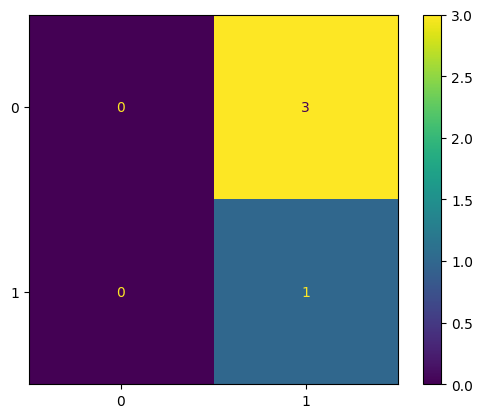

In [106]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# test_labels = [0, 1, 2, 1, 0]
# y_pred      = [0, 1, 2, 1, 1]
confusion_matrices = multilabel_confusion_matrix(ytrue, yhat)
for confusion_matrix in confusion_matrices:
    disp = ConfusionMatrixDisplay(confusion_matrix, display_labels=ytrue)
    disp.plot(include_values=True, cmap="viridis", ax=None, xticks_rotation="vertical")
    plt.show()